In [1]:
import pandas as pd
import os
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from dotenv import load_dotenv
from datetime import datetime

import project3_utilities as p3utils

In [11]:
ticker_symbol = "TSLA"

# Capture the runtime so we can use it for reference later, that way when
# the model and the other outputs are saved, they have a common reference.
unixtime = int(datetime.now().timestamp())

# Pull the stock data from Yahoo! Finance
tesla_df = yf.Ticker(ticker_symbol).history(period='max').reset_index()
tesla_df

# Because I'm paranoid about getting API banned, write this data to a file.
tesla_df.to_csv(f'Stock_Data/{ticker_symbol}-YahooData-{unixtime}.csv')

# Load the data
#tesla_df = pd.read_csv('Stock_Data/TSLA-YahooData-1722104572.csv')

In [3]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=64, return_sequences=True))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dense(units=32))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [4]:
# Get the predictions
(predictions, model) = p3utils.get_LSTM_predictions(df=tesla_df, 
                                           ticker_symbol=ticker_symbol, 
                                           train_test_split=0.8, 
                                           model=model, 
                                           window_size=100)

model.save(f'Saved_Models/{ticker_symbol}-Model-{unixtime}.keras')


2734/2734 ━━━━━━━━━━━━━━━━━━━━ 32s 11ms/step - loss: 0.0017
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/Users/brandon/OSU/challenges/OSU_AI_Project3/project3_utilities.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual['Predictions'] = predictions


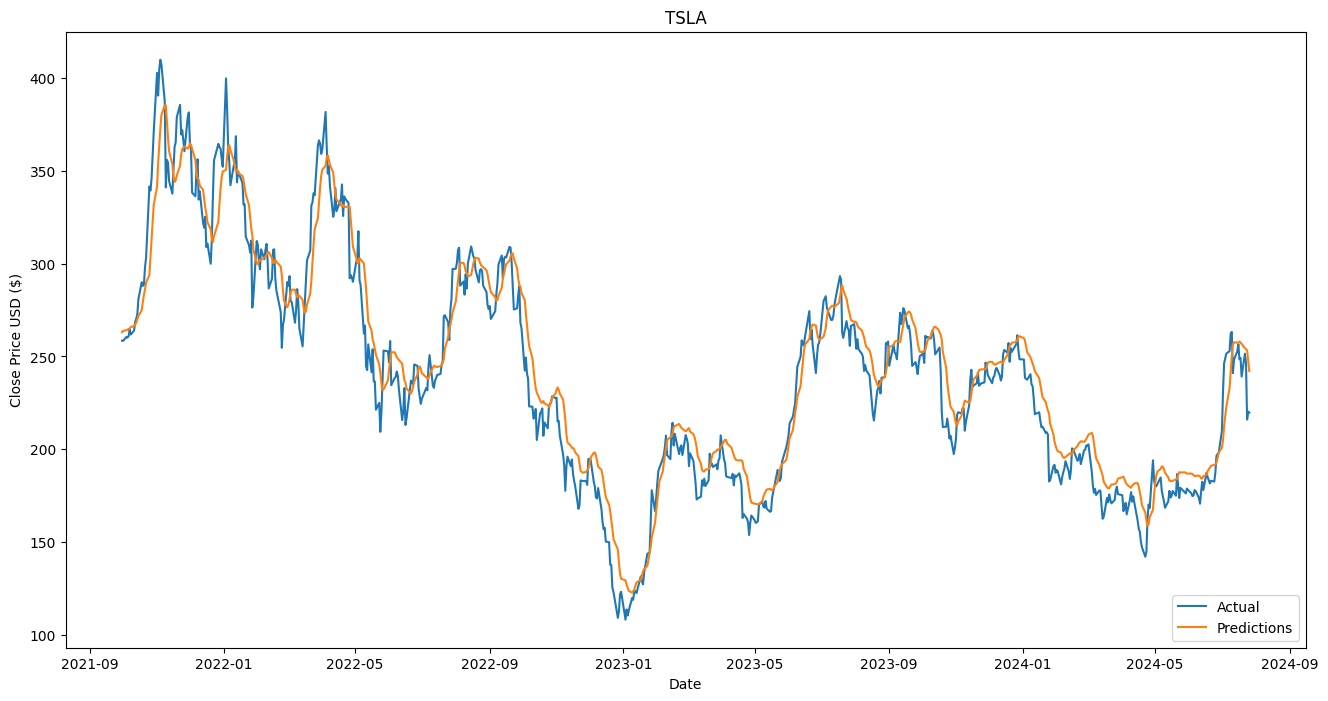

In [5]:
# Plot the predictions
p3utils.plot_predictions(df=tesla_df, 
                         ticker_symbol=ticker_symbol,
                         train_test_split=0.8, 
                         predictions=predictions, 
                         show_all=False).show()

In [6]:
# Now we need to determine if we buy or sell
tesla_df = p3utils.generate_buy_sell(tesla_df, predictions)
tesla_df[["Date", "Open", "Buy_Sell", "Close"]].tail(10)

,Date,Open,Buy_Sell,Close
3533,2024-07-15 00:00:00-04:00,255.970001,BUY,252.639999
3534,2024-07-16 00:00:00-04:00,255.309998,BUY,256.559998
3535,2024-07-17 00:00:00-04:00,252.729996,SELL,248.500000
3536,2024-07-18 00:00:00-04:00,251.089996,BUY,249.229996
3537,2024-07-19 00:00:00-04:00,247.789993,SELL,239.199997
3538,2024-07-22 00:00:00-04:00,244.210007,BUY,251.509995
3539,2024-07-23 00:00:00-04:00,253.600006,SELL,246.380005
3540,2024-07-24 00:00:00-04:00,225.419998,SELL,215.990005
3541,2024-07-25 00:00:00-04:00,216.800003,BUY,220.250000
3542,2024-07-26 00:00:00-04:00,221.190002,SELL,219.800003


In [7]:
# Now test if the model worked:
(tesla_df, profit_total) = p3utils.score_the_model(tesla_df)

display(tesla_df.tail(10))
print(f"Using this model, we would have made ${profit_total} by following the BUY instruction.")

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Predictions,Buy_Sell,Profit
3533,2024-07-15 00:00:00-04:00,255.970001,265.600006,251.729996,252.639999,146912900,0.0,0.0,257.415283,BUY,-3.330002
3534,2024-07-16 00:00:00-04:00,255.309998,258.619995,245.800003,256.559998,126332500,0.0,0.0,257.380432,BUY,1.250000
3535,2024-07-17 00:00:00-04:00,252.729996,258.470001,246.179993,248.500000,115584800,0.0,0.0,258.037445,SELL,0.000000
3536,2024-07-18 00:00:00-04:00,251.089996,257.140015,247.199997,249.229996,110869000,0.0,0.0,257.514008,BUY,-1.860001
3537,2024-07-19 00:00:00-04:00,247.789993,249.440002,236.830002,239.199997,87403900,0.0,0.0,256.78537,SELL,0.000000
3538,2024-07-22 00:00:00-04:00,244.210007,253.210007,243.750000,251.509995,101225400,0.0,0.0,254.423813,BUY,7.299988
3539,2024-07-23 00:00:00-04:00,253.600006,255.759995,245.630005,246.380005,111928200,0.0,0.0,253.917999,SELL,0.000000
3540,2024-07-24 00:00:00-04:00,225.419998,225.990005,214.710007,215.990005,167942900,0.0,0.0,253.342316,SELL,0.000000
3541,2024-07-25 00:00:00-04:00,216.800003,226.000000,216.229996,220.250000,100636500,0.0,0.0,247.836487,BUY,3.449997
3542,2024-07-26 00:00:00-04:00,221.190002,222.279999,215.330002,219.800003,94483000,0.0,0.0,242.111282,SELL,0.000000


Using this model, we would have made $2555.0482308864594 by following the BUY instruction.


In [10]:
# Finally, let's write this data to a file for reference later
tesla_df.to_csv(f'Saved_Predictions/{ticker_symbol}-Predictions-{unixtime}.csv')